In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

In [2]:
REVIEW_FOLDER = os.path.join('dataset', 'review.json')
BUSINESS_FOLDER = os.path.join('dataset', 'business.json')
CHECKIN_FOLDER = os.path.join('dataset', 'checkin.json')
TIP_FOLDER = os.path.join('dataset', 'tip.json')
USER_FOLDER = os.path.join('dataset', 'user.json')

In [3]:
review_data = pd.read_json(REVIEW_FOLDER, lines=True, chunksize=200000)
# business_data = pd.read_json(BUSINESS_FOLDER, lines=True)
# checkin_data = pd.read_json(CHECKIN_FOLDER, lines=True)
# tip_data = pd.read_json(TIP_FOLDER, lines=True)
# user_data = pd.read_json(USER_FOLDER, lines=True, chunksize=500000)

In [4]:
for rev_data in review_data:
    break
# for use_data in user_data:
#     break

Lets see how many reviews we have

In [5]:
rev_data.shape

(200000, 9)

Let's take a look at the data. Make sure its tidy.

In [6]:
rev_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
business_id    200000 non-null object
cool           200000 non-null int64
date           200000 non-null datetime64[ns]
funny          200000 non-null int64
review_id      200000 non-null object
stars          200000 non-null int64
text           200000 non-null object
useful         200000 non-null int64
user_id        200000 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 13.7+ MB


Beautiful. Would you look at that!! 

In [7]:
rev_data.describe()

,cool,funny,stars,useful
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.515360,0.410400,3.697465,0.999285
std,1.874882,1.598935,1.428229,2.334991
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,4.000000,0.000000
75%,0.000000,0.000000,5.000000,1.000000
max,104.000000,114.000000,5.000000,113.000000


In [8]:
rev_data.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,uYHaNptLzDLoV_JZ_MuzUA,0,2016-07-12,0,VfBHSwC5Vz_pbFluy07i9Q,5,My girlfriend and I stayed here for 3 nights a...,0,cjpdDjZyprfyDG3RlkVG3w
1,uYHaNptLzDLoV_JZ_MuzUA,0,2016-10-02,0,3zRpneRKDsOPq92tq7ybAA,3,If you need an inexpensive place to stay for a...,0,bjTcT8Ty4cJZhEOEo01FGA
2,uYHaNptLzDLoV_JZ_MuzUA,0,2015-09-17,0,ne5WhI1jUFOcRn-b-gAzHA,3,Mittlerweile gibt es in Edinburgh zwei Ableger...,0,AXgRULmWcME7J6Ix3I--ww
3,uYHaNptLzDLoV_JZ_MuzUA,0,2016-08-21,0,llmdwOgDReucVoWEry61Lw,4,Location is everything and this hotel has it! ...,0,oU2SSOmsp_A8JYI7Z2JJ5w
4,uYHaNptLzDLoV_JZ_MuzUA,0,2013-11-20,0,DuffS87NaSMDmIfluvT83g,5,gute lage im stadtzentrum. shoppingmeile und s...,0,0xtbPEna2Kei11vsU-U2Mw


## Classification - NLP!!

Is it possible to predict the rating given just by the review? 

First, lets see if we can find maybe a significant characteristic from our reviews.
Without any actual language processing, we can look at the string length of the reviews.

In [10]:
rev_data['text length'] = rev_data['text'].apply(len)

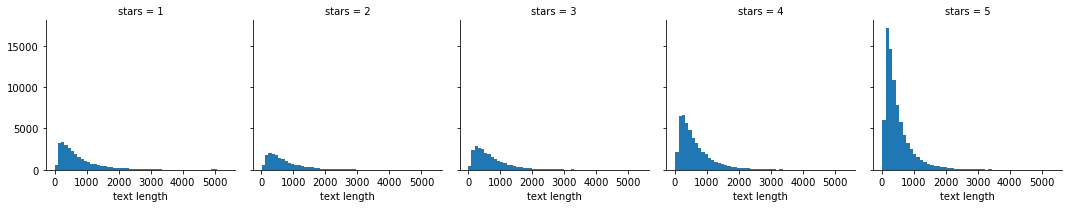

In [11]:
g = sns.FacetGrid(data=rev_data, col='stars')
g.map(plt.hist, 'text length', bins=50)

We can see that the distributions across the string lengths are similar with a higher distributional mass for shorter reviews across all stars. We can still see that there are much more 5 stars reviews with shorter length strings than the rest.
Let's show this claim specfically.


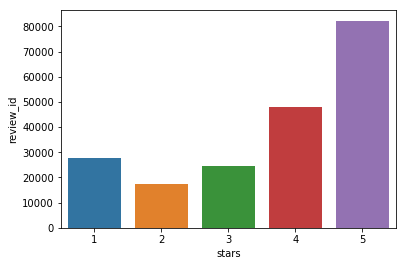

In [24]:
from collections import Counter
star_counter = rev_data.groupby('stars').count()
sns.barplot(x=star_counter.index, y='review_id', data=star_counter)

But maybe we shouldn't be looking at the string length, rather the average length of a word, possibly because longer words probably occur where people put more effort and maybe they put more effort in 5 star reviews.

In [27]:
from nltk.tokenize import RegexpTokenizer
from functools import reduce
#this breaks a sentence into a list of words
tokenizer = RegexpTokenizer(r'\w+')
#after mapping from string to length of strings, compute the mean to get the average
func = lambda x: np.mean(list(map(lambda y: len(y), tokenizer.tokenize(x))))
rev_data['average word length'] = rev_data['text'].apply(func)


In [33]:
rev_data.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,text length,word length
0,uYHaNptLzDLoV_JZ_MuzUA,0,2016-07-12,0,VfBHSwC5Vz_pbFluy07i9Q,5,My girlfriend and I stayed here for 3 nights a...,0,cjpdDjZyprfyDG3RlkVG3w,1150,4.427885
1,uYHaNptLzDLoV_JZ_MuzUA,0,2016-10-02,0,3zRpneRKDsOPq92tq7ybAA,3,If you need an inexpensive place to stay for a...,0,bjTcT8Ty4cJZhEOEo01FGA,902,4.153846
2,uYHaNptLzDLoV_JZ_MuzUA,0,2015-09-17,0,ne5WhI1jUFOcRn-b-gAzHA,3,Mittlerweile gibt es in Edinburgh zwei Ableger...,0,AXgRULmWcME7J6Ix3I--ww,2451,5.017677
3,uYHaNptLzDLoV_JZ_MuzUA,0,2016-08-21,0,llmdwOgDReucVoWEry61Lw,4,Location is everything and this hotel has it! ...,0,oU2SSOmsp_A8JYI7Z2JJ5w,809,3.878049
4,uYHaNptLzDLoV_JZ_MuzUA,0,2013-11-20,0,DuffS87NaSMDmIfluvT83g,5,gute lage im stadtzentrum. shoppingmeile und s...,0,0xtbPEna2Kei11vsU-U2Mw,269,5.550000


In [38]:
star_avg_words

stars
1    4.098186
2    4.104884
3    4.122668
4    4.190635
5    4.267197
Name: word length, dtype: float64

business_id                               7mGZrCzGGjS95SdRtEaGcQ
cool                                                          17
date                                         2009-05-04 00:00:00
funny                                                         25
review_id                                 gzHFIfWgiqnMIQG0NDHWQA
stars                                                          5
text           mmmmmmmmmmmmmmmmmmmmmmmmmmwowmmmmmmmmmmmmmmmmm...
useful                                                        17
user_id                                   QuZbJquRtbY9O9JrB9NpxQ
text length                                                 1727
word length                                                344.6
Name: 43464, dtype: object

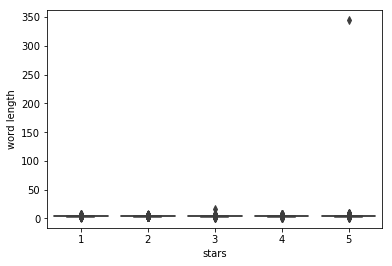

In [59]:
star_avg_words = rev_data.groupby('stars')['word length'].mean()
sns.boxplot(x='stars', y='word length', data=rev_data)

In [60]:
rev_data['word length'].idxmax()
rev_data.iloc()[rev_data['word length'].idxmax()]

business_id                               7mGZrCzGGjS95SdRtEaGcQ
cool                                                          17
date                                         2009-05-04 00:00:00
funny                                                         25
review_id                                 gzHFIfWgiqnMIQG0NDHWQA
stars                                                          5
text           mmmmmmmmmmmmmmmmmmmmmmmmmmwowmmmmmmmmmmmmmmmmm...
useful                                                        17
user_id                                   QuZbJquRtbY9O9JrB9NpxQ
text length                                                 1727
word length                                                344.6
Name: 43464, dtype: object

In [74]:
rev_data[rev_data['word length']< 200].groupby('stars')['word length'].describe()

,count,mean,std,min,25%,50%,75%,max
stars,,,,,,,,
1,27727.0,4.098186,0.337877,1.000000,3.888889,4.064103,4.261905,8.0
2,17453.0,4.104884,0.323366,1.868421,3.906166,4.071856,4.262019,7.5
3,24668.0,4.122668,0.348605,1.000000,3.912621,4.086057,4.284423,16.0
4,47904.0,4.190635,0.372745,1.321429,3.957143,4.145161,4.363636,8.0
5,82247.0,4.263059,0.414217,1.278689,4.000000,4.207715,4.459459,10.0


Seems like the average word length doesn't quite help. There is however a coorelation between stars and the mean word lengths averages. So we will continue with classification without using this feature.

First though, because of the large amount of 5 ratings, we need to minimize our dataset so that each of the stars will have an equal number of reviews. This is so that our classifier isn't biased towards 5 star ratings because it is what he saw most of.

In [30]:
from collections import Counter
#Here we create a function to balance our classes so that they are the same length
def balance_classes(df, ys):
    freqs = Counter(ys)
    xs = df.text
    # the least common class is the maximum number we want for all classes
    max_allowable = freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for i, y in enumerate(ys):
        if num_added[y] < max_allowable:
            new_ys.append(y)
            new_xs.append(xs[i])
            num_added[y] += 1
    return new_xs, new_ys

In [31]:
balanced_x, balanced_y, wordsize, lengthsize = balance_classes(rev_data, rev_data.stars)
print(Counter(balanced_y))


Counter({5: 82248, 4: 47904, 1: 27727, 3: 24668, 2: 17453})
Counter({5: 17453, 3: 17453, 4: 17453, 1: 17453, 2: 17453})


In [11]:
#split the data to train+test sets
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(balanced_x, balanced_y, test_size=0.2, random_state=42)
#Use a stemmer for all the words, and create a bag of words representation from the stemmed words.
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(ignore_stopwords=False)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer()

text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
                             ('clf-svm', LinearSVC())])

text_mnb_stemmed.fit(X_train, y_train)

predicted_mnb_stemmed = text_mnb_stemmed.predict(X_test)

np.mean(predicted_mnb_stemmed == y_test)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


0.51701323251417775

In [55]:
# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectors = vectorizer.fit_transform(balanced_x)
v.shape

(87265, 1864887)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, balanced_y, test_size=0.2, random_state=42)

In [57]:
from sklearn.svm import LinearSVC

# initialise the SVM classifier
classifier = LinearSVC()

# train the classifier
classifier.fit(X_train, y_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [58]:
preds = classifier.predict(X_test)
print(list(preds[:10]))
print(y_test[:10])


[2, 5, 3, 2, 1, 1, 3, 5, 5, 1]
[2, 5, 1, 2, 1, 1, 2, 5, 5, 1]


In [59]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, preds))

0.602016845242


In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          1       0.68      0.78      0.73      2797
          2       0.52      0.48      0.50      2748
          3       0.52      0.48      0.50      2811
          4       0.52      0.46      0.49      2802
          5       0.67      0.74      0.70      2808

avg / total       0.58      0.59      0.58     13966



In [23]:
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()),
                         ('clf-svm', LinearSVC(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42))])

parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(balanced_x, balanced_y)


gs_clf_svm.best_score_


0.47821361058601136